In [14]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras.backend as K
from tensorflow import keras

import albumentations as A
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()

%matplotlib inline

Segmentation Models: using `keras` framework.


In [2]:
BASE_DIR = ''
TRAIN_DIR = BASE_DIR + 'cropped_img/'
MASK_DIR = BASE_DIR + 'cropped_mask/'
INPUT_SIZE = (256,256,3)

In [3]:
train = os.listdir(TRAIN_DIR)
mask = os.listdir(MASK_DIR)

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(mask)}. ---> {mask[:3]}")

Train files: 1764. ---> ['0.png', '1.png', '10.png']
Test files :  1764. ---> ['0.png', '1.png', '10.png']


In [4]:
out_rgb = []
out_mask = []

counter_empty = 0

for p_img, p_mask in zip(train, mask):   
    img_path = os.path.join(TRAIN_DIR, p_img)
    mask_path = os.path.join(MASK_DIR, p_mask)
    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.
    mask = cv2.imread(mask_path)
    
    mask = mask[:, :, :1]
    mask[mask > 0.] = 1.
    
    if 1 not in mask: counter_empty+=1
    
    if not(1 not in mask and counter_empty >= 40):
        out_rgb += [img]
        out_mask += [mask]
        

out_rgb = np.array(out_rgb, dtype = 'float32')
out_mask = np.array(out_mask, dtype = 'float32')

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    out_rgb, 
    out_mask, 
    test_size=0.05, 
    shuffle=True)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((287, 256, 256, 3), (16, 256, 256, 3), (287, 256, 256, 1), (16, 256, 256, 1))

In [10]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=256, width=256, p=0.5),
        A.PadIfNeeded(min_height=256, min_width=256, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

In [11]:
def make_image_gen(X_train, y_train, aug, batch_size):
    aug_x = []
    aug_y = []
    while True:
        for i in range(X_train.shape[0]): 
            augmented = aug(image=X_train[i], mask=y_train[i])
            x, y = augmented['image'],  augmented['mask']
            aug_x.append(x)
            aug_y.append(y)
            if len(aug_x)>=batch_size:
                yield np.array(aug_x, dtype = 'float32'), np.array(aug_y, dtype = 'float32')
                aug_x, aug_y=[], []

In [12]:
train_gen = make_image_gen(X_train, y_train, aug, 32)
aug_x, aug_y = next(train_gen)

In [13]:
np.shape(aug_x), np.shape(aug_y)

((32, 256, 256, 3), (32, 256, 256, 1))

In [16]:
IoU = tf.keras.metrics.MeanIoU(num_classes=2)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [17]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='crusa.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)   
]

In [18]:
model = sm.Unet('efficientnetb0', classes=1, input_shape=(256, 256, 3), activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=FocalLoss, metrics = [IoU, dice_coef] )

Segmentation Models: using `keras` framework.


In [21]:
model.fit_generator(generator=make_image_gen(X_train, y_train, aug, 16),epochs=50, steps_per_epoch = 200, callbacks = callbacks,validation_data = (X_test, y_test))

Epoch 1/50
200/200 [==============================] - 47s 220ms/step - loss: 0.0221 - mean_io_u: 0.4926 - dice_coef: 0.0247 - val_loss: 0.0204 - val_mean_io_u: 0.4934 - val_dice_coef: 0.0264

Epoch 00001: val_loss improved from inf to 0.02044, saving model to crusa.h5


C:\Users\Andrey\anaconda3\envs\ev_2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
200/200 [==============================] - 43s 213ms/step - loss: 0.0150 - mean_io_u: 0.4931 - dice_coef: 0.0288 - val_loss: 0.0202 - val_mean_io_u: 0.4934 - val_dice_coef: 0.0249

Epoch 00002: val_loss improved from 0.02044 to 0.02015, saving model to crusa.h5
Epoch 3/50
200/200 [==============================] - 42s 211ms/step - loss: 0.0148 - mean_io_u: 0.4928 - dice_coef: 0.0317 - val_loss: 0.0140 - val_mean_io_u: 0.4934 - val_dice_coef: 0.0384

Epoch 00003: val_loss improved from 0.02015 to 0.01399, saving model to crusa.h5
Epoch 4/50
200/200 [==============================] - 43s 213ms/step - loss: 0.0139 - mean_io_u: 0.4933 - dice_coef: 0.0314 - val_loss: 0.0125 - val_mean_io_u: 0.4934 - val_dice_coef: 0.0515

Epoch 00004: val_loss improved from 0.01399 to 0.01246, saving model to crusa.h5
Epoch 5/50
200/200 [==============================] - 42s 212ms/step - loss: 0.0134 - mean_io_u: 0.4933 - dice_coef: 0.0331 - val_loss: 0.0124 - val_mean_io_u: 0.4934 - val_dice_coe

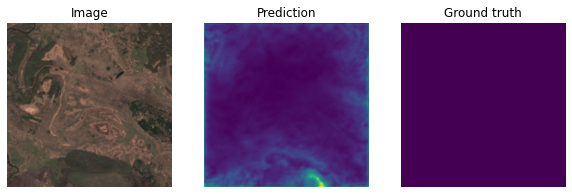

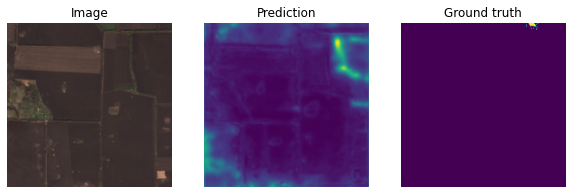

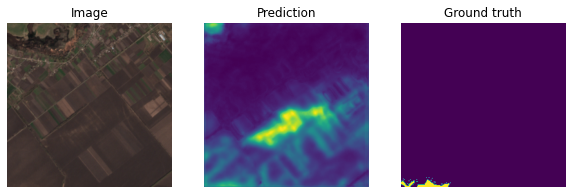

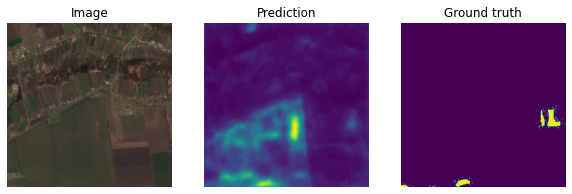

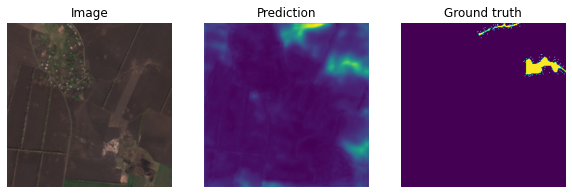

In [26]:
rows = 1
columns = 3
preds = model.predict(X_test)

for img, pred, g_truth in zip(X_test[5:10], preds[5:10], y_test[5:10]):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    #pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(g_truth, interpolation=None)
    plt.axis('off')
    plt.title("Ground truth")

In [27]:
model.save('model.h5')

In [24]:
model = keras.models.load_model('model.h5', custom_objects={'FocalLoss': FocalLoss, 'dice_coef': dice_coef})

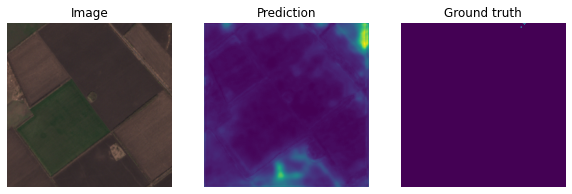

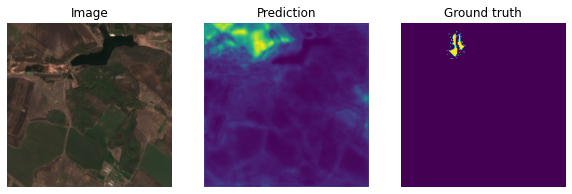

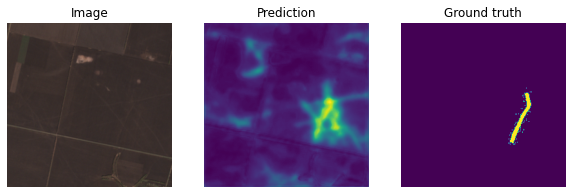

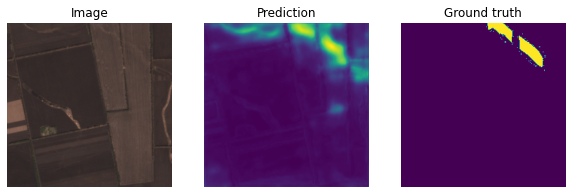

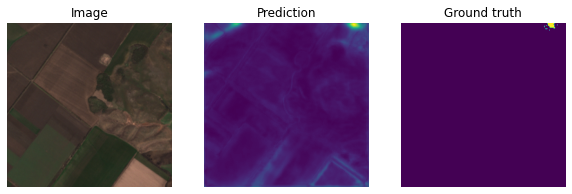

In [28]:
rows = 1
columns = 3
preds = model.predict(X_test)

for img, pred, g_truth in zip(X_test[10:15], preds[10:15], y_test[10:15]):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    #pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(g_truth, interpolation=None)
    plt.axis('off')
    plt.title("Ground truth")